# Enhancing Airline Service Through Automated Sentiment Analysis of Customer Reviews



### Import Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Data Preparation (Loading CSV)

In [27]:
data = pd.read_csv('data.csv')

In [28]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Airline Name            23171 non-null  object 
 2   Overall_Rating          23171 non-null  object 
 3   Review_Title            23171 non-null  object 
 4   Review Date             23171 non-null  object 
 5   Verified                23171 non-null  bool   
 6   Review                  23171 non-null  object 
 7   Aircraft                7129 non-null   object 
 8   Type Of Traveller       19433 non-null  object 
 9   Seat Type               22075 non-null  object 
 10  Route                   19343 non-null  object 
 11  Date Flown              19417 non-null  object 
 12  Seat Comfort            19016 non-null  float64
 13  Cabin Staff Service     18911 non-null  float64
 14  Food & Beverages        14500 non-null

(23171, 20)

In [29]:
data.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


### Data Cleaning

In [30]:
# Selecting the relevant features for sentiment analysis 
columns_to_keep = [
    'Airline Name', 'Overall_Rating', 'Review_Title', 'Review Date', 
    'Recommended', 'Review', 'Type Of Traveller', 'Seat Type'
]

# Dropping the unnecessary columns
df_cleaned = data[columns_to_keep].copy()

# Display the cleaned dataframe information and first few rows
df_cleaned.info(),df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Airline Name       23171 non-null  object
 1   Overall_Rating     23171 non-null  object
 2   Review_Title       23171 non-null  object
 3   Review Date        23171 non-null  object
 4   Recommended        23171 non-null  object
 5   Review             23171 non-null  object
 6   Type Of Traveller  19433 non-null  object
 7   Seat Type          22075 non-null  object
dtypes: object(8)
memory usage: 1.4+ MB


(None,
     Airline Name Overall_Rating                           Review_Title  \
 0    AB Aviation              9                "pretty decent airline"   
 1    AB Aviation              1                   "Not a good airline"   
 2    AB Aviation              1         "flight was fortunately short"   
 3  Adria Airways              1    "I will never fly again with Adria"   
 4  Adria Airways              1  "it ruined our last days of holidays"   
 
            Review Date Recommended  \
 0   11th November 2019         yes   
 1       25th June 2019          no   
 2       25th June 2019          no   
 3  28th September 2019          no   
 4  24th September 2019          no   
 
                                               Review Type Of Traveller  \
 0    Moroni to Moheli. Turned out to be a pretty ...      Solo Leisure   
 1   Moroni to Anjouan. It is a very small airline...      Solo Leisure   
 2    Anjouan to Dzaoudzi. A very small airline an...      Solo Leisure   
 3   

In [31]:
# Convert Overall_Rating to numeric 
unique_ratings = df_cleaned['Overall_Rating'].unique()
print(unique_ratings)

# Step 2: Convert 'Overall_Rating' to numeric and handle non-numeric values (errors='coerce' converts non-numeric values to NaN)
df_cleaned['Overall_Rating'] = pd.to_numeric(df_cleaned['Overall_Rating'], errors='coerce')

# Check how many missing values were introduced in 'Overall_Rating'
df_cleaned['Overall_Rating'].isnull().sum()


['9' '1' '8' '2' '3' '5' '6' '7' '4' 'n']


842

In [32]:
# Remove rows with missing 'Overall_Rating' values
df_cleaned = df_cleaned.dropna(subset=['Overall_Rating'])

# Display the shape and info of the cleaned dataframe
print(df_cleaned.shape)
print(df_cleaned.info())

(22329, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22329 entries, 0 to 23170
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Airline Name       22329 non-null  object 
 1   Overall_Rating     22329 non-null  float64
 2   Review_Title       22329 non-null  object 
 3   Review Date        22329 non-null  object 
 4   Recommended        22329 non-null  object 
 5   Review             22329 non-null  object 
 6   Type Of Traveller  19433 non-null  object 
 7   Seat Type          21761 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.5+ MB
None


In [33]:
#Display first few rows of the df_cleaned
df_cleaned.head()

,Airline Name,Overall_Rating,Review_Title,Review Date,Recommended,Review,Type Of Traveller,Seat Type
0,AB Aviation,9.0,"""pretty decent airline""",11th November 2019,yes,Moroni to Moheli. Turned out to be a pretty ...,Solo Leisure,Economy Class
1,AB Aviation,1.0,"""Not a good airline""",25th June 2019,no,Moroni to Anjouan. It is a very small airline...,Solo Leisure,Economy Class
2,AB Aviation,1.0,"""flight was fortunately short""",25th June 2019,no,Anjouan to Dzaoudzi. A very small airline an...,Solo Leisure,Economy Class
3,Adria Airways,1.0,"""I will never fly again with Adria""",28th September 2019,no,Please do a favor yourself and do not fly wi...,Solo Leisure,Economy Class
4,Adria Airways,1.0,"""it ruined our last days of holidays""",24th September 2019,no,Do not book a flight with this airline! My fr...,Couple Leisure,Economy Class


In [34]:
# Label encode 'Recommended' as binary values
df_cleaned['Recommended'] = df_cleaned['Recommended'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

# Handle missing values in 'Type Of Traveller' and 'Seat Type' by filling with 'Unknown'
df_cleaned['Type Of Traveller'].fillna('Unknown', inplace=True)
df_cleaned['Seat Type'].fillna('Unknown', inplace=True)

# Display the final cleaned dataframe information and first few rows
df_cleaned_info_final = df_cleaned.info()
df_cleaned_head_final = df_cleaned.head()

df_cleaned_info_final, df_cleaned_head_final


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22329 entries, 0 to 23170
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Airline Name       22329 non-null  object 
 1   Overall_Rating     22329 non-null  float64
 2   Review_Title       22329 non-null  object 
 3   Review Date        22329 non-null  object 
 4   Recommended        22329 non-null  int64  
 5   Review             22329 non-null  object 
 6   Type Of Traveller  22329 non-null  object 
 7   Seat Type          22329 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB


(None,
     Airline Name  Overall_Rating                           Review_Title  \
 0    AB Aviation             9.0                "pretty decent airline"   
 1    AB Aviation             1.0                   "Not a good airline"   
 2    AB Aviation             1.0         "flight was fortunately short"   
 3  Adria Airways             1.0    "I will never fly again with Adria"   
 4  Adria Airways             1.0  "it ruined our last days of holidays"   
 
            Review Date  Recommended  \
 0   11th November 2019            1   
 1       25th June 2019            0   
 2       25th June 2019            0   
 3  28th September 2019            0   
 4  24th September 2019            0   
 
                                               Review Type Of Traveller  \
 0    Moroni to Moheli. Turned out to be a pretty ...      Solo Leisure   
 1   Moroni to Anjouan. It is a very small airline...      Solo Leisure   
 2    Anjouan to Dzaoudzi. A very small airline an...      Solo Leis

### Exploratory Data Analysis

#### Statistical Summary

In [35]:
df_cleaned.shape
df_cleaned.isnull().sum()

Airline Name         0
Overall_Rating       0
Review_Title         0
Review Date          0
Recommended          0
Review               0
Type Of Traveller    0
Seat Type            0
dtype: int64

#### Class Distribution

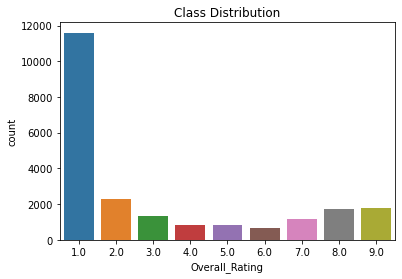

In [36]:
# Plotting the distribution of the "Overall Rating" dependent variable
sns.countplot(x='Overall_Rating', data=df_cleaned)
plt.title('Class Distribution')
plt.show()

In [37]:
# Get percentage distribution of "Overall Rating"
class_distribution_percentage = df_cleaned['Overall_Rating'].value_counts(normalize=True) * 100

print(class_distribution_percentage)

1.0    51.927986
2.0    10.282592
9.0     7.917954
8.0     7.868691
3.0     6.072820
7.0     5.338349
4.0     3.847015
5.0     3.717139
6.0     3.027453
Name: Overall_Rating, dtype: float64


#### Distribution of Features

#### Text Preprocessing

In [41]:
# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Function to clean text for "Review" column of df_cleaned
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply cleaning to "Review"
df_cleaned['Cleaned_Review'] = df_cleaned['Review'].apply(preprocess_text)
df_cleaned["Cleaned_Review"].head() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    moroni moheli turned pretty decent airline onl...
1    moroni anjouan small airline ticket advised tu...
2    anjouan dzaoudzi small airline airline based c...
3    please favor fly adria route munich pristina j...
4    book flight airline friend returned sofia amst...
Name: Cleaned_Review, dtype: object

#### Word Cloud Analysis

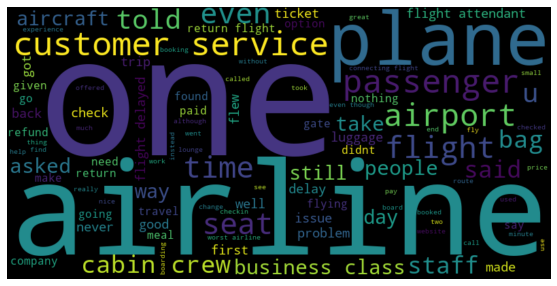

In [43]:
from wordcloud import WordCloud

# Generating word cloud from cleaned reviews
text = ' '.join(df_cleaned['Cleaned_Review'].tolist())
wordcloud = WordCloud(width=800, height=400, max_words=100).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Bigram Analysis

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a count vectorizer for most common bigrams(Phrases of 2 words)
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=19)

# Fit and transform the cleaned review data
bigrams = vectorizer.fit_transform(df_cleaned['Cleaned_Review'])

# Geting the bigram frequencies
bigram_frequencies = pd.DataFrame(bigrams.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

print(bigram_frequencies)

customer service          3942
cabin crew                2365
business class            2224
flight delayed            1568
return flight             1315
flight attendants         1263
even though               1014
connecting flight         1002
flight cancelled           932
never fly                  932
ground staff               913
worst airline              901
first time                 882
next day                   879
hour flight                852
flight time                806
boarding pass              791
leg room                   778
inflight entertainment     751
dtype: int64


#### Finding the Sentiment Polarity Distribution

  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.5
    Uninstalling nltk-3.6.5:
      Successfully uninstalled nltk-3.6.5


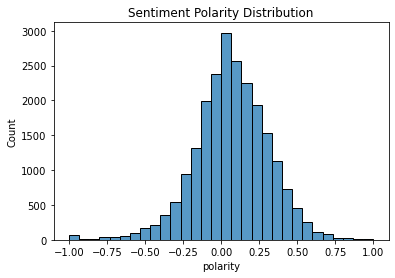

In [48]:
%pip install textblob
from textblob import TextBlob

# Calculate polarity
# Take note that this current polarity is calculated using the TextBlob library

df_cleaned['polarity'] = df_cleaned['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot the polarity distribution
sns.histplot(df_cleaned['polarity'], bins=30)
plt.title('Sentiment Polarity Distribution')
plt.show()

In [50]:
# After additional columns added to df_cleaned, this is how it looks like now
df_cleaned.tail()

,Airline Name,Overall_Rating,Review_Title,Review Date,Recommended,Review,Type Of Traveller,Seat Type,Cleaned_Review,polarity
23166,ZIPAIR,1.0,"""customer service is terrible""",5th July 2022,0,Bangkok to Tokyo. I’ve flown many low cost ai...,Couple Leisure,Economy Class,bangkok tokyo ive flown many low cost airlines...,-0.063889
23167,ZIPAIR,1.0,"""Avoid at all costs""",1st June 2022,0,Avoid at all costs. I booked flights to go f...,Solo Leisure,Economy Class,avoid costs booked flights go singapore tokyo ...,0.136364
23168,ZIPAIR,3.0,"""Will not recommend to anyone""",31st May 2022,0,Flight was leaving at 23.15 and after an hou...,Business,Economy Class,flight leaving 2315 hour half flying get back ...,0.028680
23169,ZIPAIR,6.0,"""It was immaculately clean""",23rd May 2022,1,Zipair is JAL’s budget airline. They don’t ha...,Business,Business Class,zipair jals budget airline dont classes travel...,0.216805
23170,ZIPAIR,1.0,"""lost all of our money with no refund""",20th May 2022,0,They lied about connection in Narita and we ...,Solo Leisure,Economy Class,lied connection narita lost money refund agree...,0.000000


#### Correlation Matrix


<AxesSubplot:>

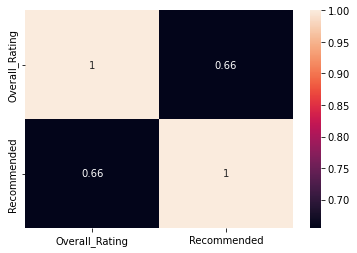

In [40]:
# With only 1 numerical independent variable, the correlation matrix is as follows
sns.heatmap(df_cleaned.corr(), annot=True)

#### Pairplot of Features
